#Image captioing model
This model uses seq2seq architecure with teacher forcing to caption images from MS COCO dataset.

Example image from model after training:

![](https://drive.google.com/uc?id=1xdcSs3naEnZc5gzhwQTGPCRx2W11qli0)

Note that attention can be added upon this architecure, but it takes more time to train.

###Importing relevant libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

keras = tf.keras

Using TensorFlow backend.


##Setting config parameters

In [0]:
max_cap_len = 15  # Determines max length of captioning sentences
img_dimension = 299 # Determines the height and width of images
num_words = 10000 # Determines vocab size to tokenize and train on
encoding_size = 512 # Determines dimension of the encodings of images
LSTM_size = 512 
batch_size = 128
n_epochs = 15
Buffer_size = 1000
validation_and_test_split = 0.2
test_to_val_split = 0.5
num_examples = None # Determines number of overall read samples. If set to none all samples will be read as long as they don't exceed max_cap_len

##Data Preprocessing


###Downloading the MS COCO dataset

Both this cell and the one below it were copied from a google documentation.

I have done some editing like stripping out most of 'a', 'an' and 'the' words as they had little value and were too common.

Link of the google doucmenatin:

https://www.tensorflow.org/tutorials/text/image_captioning#model

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'

annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'

image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
PATH = os.path.dirname(image_zip) + image_folder
os.remove(image_zip)



13510574080/13510573713 [==============================] - 788s 0us/step


###Reading the data

In [4]:
# Read the json file
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = annot['caption']

    #Removing the word 'a' from captions
    caption = caption.replace(" a "," ")
    caption = caption.replace("A ","")
    #Removing the word 'an' from captions
    caption = caption.replace("An ","")
    caption = caption.replace(" an "," ")
    #Removing the word 'the' from captions
    caption = caption.replace(" the "," ")
    caption = caption.replace("The ","")

    #Load only captions that don't exceed maximum length
    if len(caption.split(" ")) > max_cap_len:
      continue
    else:
      caption = '<sos> ' + caption + ' <eos>'
      image_id = annot['image_id']
      full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

      all_img_name_vector.append(full_coco_image_path)
      all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=42)
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

caption_train, captions_test, img_name_vector_train, img_name_vector_test = train_test_split(train_captions,
                                                                      img_name_vector,
                                                                      test_size= validation_and_test_split)

caption_val, caption_test, img_name_vector_val, img_name_vector_test = train_test_split(captions_test,
                                                        img_name_vector_test,
                                                        test_size= test_to_val_split)
num_samples = len(img_name_vector)
assert len(train_captions) == len(img_name_vector)
print("Loaded %d samples" %(num_samples))
print("Loaded %d train samples" %(len(caption_train)))
print("Loaded %d valid samples" %(len(caption_val)))
print("Loaded %d test samples" %(len(caption_test)))


Loaded 409297 samples
Loaded 327437 train samples
Loaded 40930 valid samples
Loaded 40930 test samples


###Tokenizing and padding captions

In [33]:
tok = keras.preprocessing.text.Tokenizer(num_words = num_words
                                         ,filters ="!?,'()_-+=&*$#@.",oov_token="<unk>")
tok.fit_on_texts(caption_train)
captions_train = tok.texts_to_sequences(caption_train)
if num_words == None:
  words = len(tok.word_index)
else:
  words = num_words
captions_train = keras.preprocessing.sequence.pad_sequences(captions_train, padding='post',maxlen=max_cap_len + 2)
print("Examlpe:", captions_train[np.random.randint(low=0, high= len(captions_train) - 1,size=1)[0]])
print("Found %d unique words" %(words))

Examlpe: [  2  21  52   4  69 343  19  11  29 121   3   0   0   0   0   0   0]
Found 10000 unique words


In [0]:
captions_valid = tok.texts_to_sequences(caption_val)
captions_valid = keras.preprocessing.sequence.pad_sequences(captions_valid, padding='post',maxlen=max_cap_len + 2)

###Defining preprocessing functions of dataset
tf.data api is used for making efficient input pipelines as the data is huge for ram.

In [0]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (img_dimension, img_dimension))
  return img

In [0]:
def preprocess_func(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_train,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [0]:
def preprocess_func_val(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_val,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]

  h_and_c_init = tf.zeros((LSTM_size))
  
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [0]:
#Creating an array to index each img path for reading 
path_index_vec_train = np.array(list(range(0,len(img_name_vector_train)))).reshape(-1,1)
path_index_vec_val = np.array(list(range(0,len(img_name_vector_val)))).reshape(-1,1)

dataset1_train = tf.data.Dataset.from_tensor_slices(path_index_vec_train)
dataset2_train = tf.data.Dataset.from_tensor_slices(captions_train)
dataset = tf.data.Dataset.zip((dataset1_train,dataset2_train))
dataset = dataset.map(preprocess_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset1_val = tf.data.Dataset.from_tensor_slices(path_index_vec_val)
dataset2_val = tf.data.Dataset.from_tensor_slices(captions_valid)
dataset_val = tf.data.Dataset.zip((dataset1_val,dataset2_val))
dataset_val = dataset_val.map(preprocess_func_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [0]:
dataset = dataset.shuffle(Buffer_size).batch(batch_size,drop_remainder=True).prefetch(1)
dataset_val = dataset_val.shuffle(Buffer_size).batch(256,drop_remainder=True).prefetch(1)

##Building the model

###Downloading Inception and freezing it.

In [40]:
from keras.applications.inception_v3 import preprocess_input


incep = keras.applications.inception_v3.InceptionV3(input_shape=(img_dimension,img_dimension,3),
                                                    include_top=False)
incep.trainable=False
incep.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [41]:
encoder = keras.models.Sequential([
                                   keras.layers.Lambda(preprocess_input,input_shape=(img_dimension,img_dimension,3),name="preprocessing_layer"),
                                   incep,
                                   keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer"),
                                   keras.layers.Reshape((8*8,encoding_size),name="reshape_layer")
],name="Encoder")
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing_layer (Lambda) (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
encoding_layer (Dense)       (None, 8, 8, 512)         1049088   
_________________________________________________________________
reshape_layer (Reshape)      (None, 64, 512)           0         
Total params: 22,851,872
Trainable params: 1,049,088
Non-trainable params: 21,802,784
_________________________________________________________________


###Completing the model

####Building attention mechanism
This is Bahdanau attention, A soft attention mechanism that works through linear combination of previous state and the whole image.

In [0]:
W1 = keras.layers.Dense(512,name="W1")
W2 = keras.layers.Dense(512,name="W2")
V = keras.layers.Dense(1,name="V")
repeater = keras.layers.RepeatVector(8*8)
doter = keras.layers.Dot(axes=1)
concatenator = keras.layers.Concatenate()

def attention_step(enc,h_prev):
  h = repeater(h_prev)
  score = tf.nn.tanh(W1(enc)+ W2(h))

  alphas =tf.nn.softmax(V(score),axis=1)

  context = doter([alphas,enc])
  return context

####Building the deoder

This decoder goes one time-step at a time.

So, a custom training function is required.

In [46]:
encodings = keras.layers.Input(shape=(8*8,encoding_size))

init_h = keras.layers.Input(shape=(LSTM_size))
init_c = keras.layers.Input(shape=(LSTM_size))

teacher_forcing = keras.layers.Input(shape=(1))

embedding_layer = keras.layers.Embedding(words+1,256,)


context_prev_tar_concat_layer = keras.layers.Concatenate()
decoder_lstm_layer = keras.layers.LSTM(LSTM_size,return_state=True,dropout=0.2)
decoder_dense_layer = keras.layers.Dense(words+1,activation='softmax')

h = init_h

c = init_c

context = attention_step(encodings,h)

embedds = embedding_layer(teacher_forcing)

decoder_lstm_input = context_prev_tar_concat_layer([context,embedds])
  
h , _ , c = decoder_lstm_layer(decoder_lstm_input,initial_state=[h,c])
  
out = decoder_dense_layer(h)

decoder = keras.models.Model([encodings,init_h,init_c,teacher_forcing],[out,h,c])
decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 64, 512)]    0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 64, 512)      0           input_20[0][0]                   
__________________________________________________________________________________________________
W1 (Dense)                      (None, 64, 512)      262656      input_19[0][0]                   
____________________________________________________________________________________________

##Defining custom loss function
This loss function masks the padded steps and also one-hot enodes the targets

In [0]:
def sparse_it_up(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  real = tf.cast(real,tf.int64)
  real = tf.one_hot(real,words+1,axis=-1)

  loss_ = tf.losses.categorical_crossentropy(real, pred)

  mask = tf.cast(mask, dtype=tf.float32)

  loss_ *= mask

  return tf.reduce_mean(loss_)


##Defining the custom train loop

This custorm training loop was inspired from the google documentation linked above aswell.

In [0]:
optimizer = keras.optimizers.Adam()

@tf.function
def train_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [0]:
'''This function is for forward passing features for calculating losses with no backprop'''
@tf.function
def valid_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  return loss

##Training the model
One training epoch takes about 35 minutes on google colab with gpu.

So, get busy doing something else for a while! or just go for a smaller num_examples set from the configuration cell.

In [50]:
EPOCHS = 5

prev_loss = np.inf

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, ((img, s, teacher) ,target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img, s, teacher ,target)
        total_loss += t_loss

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    val_loss=0

    for (i, ((img, s, teacher) ,target)) in enumerate(dataset_val):
      val_loss += valid_step(img, s, teacher ,target)
    
    val_loss = val_loss.numpy()/((i+1)*(max_cap_len+1))
    print("val_loss=",val_loss)
    
    #This code makes sure we only save the best val_loss score weights
    if val_loss < prev_loss:
      print("Model_imporved. Saving..")

      encoder.save("encoder.hdf5")
      decoder.save("decoder.hdf5")
    
    else:
      print("Model didn't imporve.")

    prev_loss = val_loss




Epoch 1 Batch 0 Loss 5.3803
Epoch 1 Batch 50 Loss 3.5735
Epoch 1 Batch 100 Loss 3.4768
Epoch 1 Batch 150 Loss 3.4951
Epoch 1 Batch 200 Loss 3.3313
Epoch 1 Batch 250 Loss 3.1550
Epoch 1 Batch 300 Loss 2.9459
Epoch 1 Batch 350 Loss 2.8203
Epoch 1 Batch 400 Loss 2.6694
Epoch 1 Batch 450 Loss 2.4063
Epoch 1 Batch 500 Loss 2.2519
Epoch 1 Batch 550 Loss 2.3587
Epoch 1 Batch 600 Loss 2.2637
Epoch 1 Batch 650 Loss 2.2203
Epoch 1 Batch 700 Loss 2.1683
Epoch 1 Batch 750 Loss 2.2168
Epoch 1 Batch 800 Loss 2.2348
Epoch 1 Batch 850 Loss 2.0114
Epoch 1 Batch 900 Loss 2.0508
Epoch 1 Batch 950 Loss 2.0659
Epoch 1 Batch 1000 Loss 2.0126
Epoch 1 Batch 1050 Loss 1.9883
Epoch 1 Batch 1100 Loss 1.9750
Epoch 1 Batch 1150 Loss 1.9506
Epoch 1 Batch 1200 Loss 2.0289
Epoch 1 Batch 1250 Loss 2.0475
Epoch 1 Batch 1300 Loss 1.9654
Epoch 1 Batch 1350 Loss 1.9373
Epoch 1 Batch 1400 Loss 1.8826
Epoch 1 Batch 1450 Loss 1.8797
Epoch 1 Batch 1500 Loss 2.0111
Epoch 1 Batch 1550 Loss 1.9886
Epoch 1 Batch 1600 Loss 1.9775


In [0]:
# Loading the best validation accuracy score weights
encoder.load_weights("encoder.hdf5")
decoder.load_weights("decoder.hdf5")

##Prediction function
This function takes its input as path of an image and captions it

In [0]:
def caption_image(path):
  image = load_img(path)#/255.0

  encodings = encoder.predict(tf.reshape(image,(1,img_dimension,img_dimension,3)))

  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    
    texts.append(tok.index_word.get(idx))
    
    if idx == tok.word_index['<eos>']:
      break
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  print(' '.join(texts))
  plt.imshow(image/255.0)
  plt.axis("off")

###Some random predictions for fun.
Apparently the model performs well, but it sometimes deviates from its desired destination when it starts describing some details.

I have split some of the predections into the good, the meh and the ugly.

Keep in mind that most of the predections i tried on my own fell into 'the good' region.

####The good

<sos> baby boy holding toothbrush in his hand <eos>


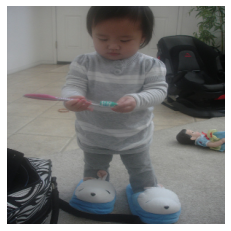

In [69]:
caption_image(img_name_vector_test[1700])

<sos> group of planes flying in formation in sky <eos>


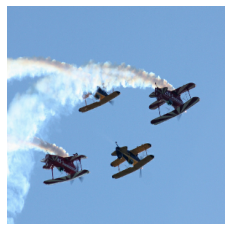

In [72]:
caption_image(img_name_vector_test[9888])

<sos> truck is parked on grass near house <eos>


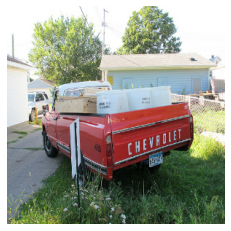

In [73]:
caption_image(img_name_vector_test[129])

<sos> black cat laying next to keyboard <eos>


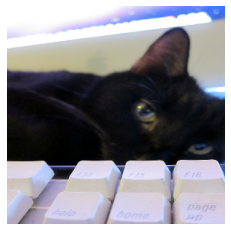

In [64]:
caption_image(img_name_vector_test[600])

<sos> old abandoned train car with graffiti on it <eos>


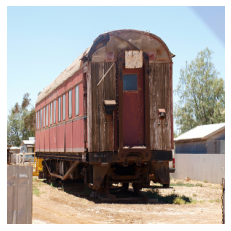

In [80]:
caption_image(img_name_vector_test[2048])

####The meh..

<sos> two birds are perched on tree limb <eos>


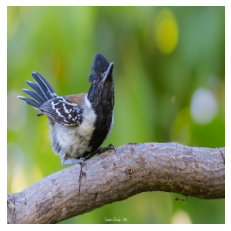

In [68]:
caption_image(img_name_vector_test[12])

<sos> a table with some food and some food on it <eos>


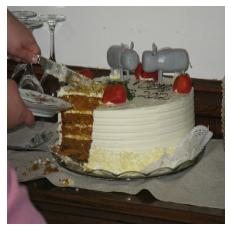

In [60]:
caption_image(img_name_vector_test[906])

<sos> man holding up piece of food in his hand <eos>


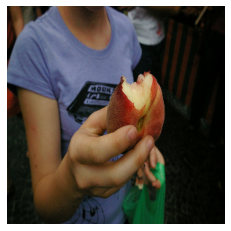

In [61]:
caption_image(img_name_vector_test[929])

<sos> woman is petting black dog with her mouth <eos>


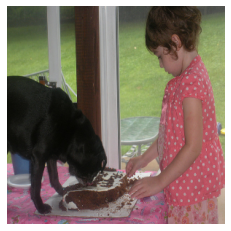

In [65]:
caption_image(img_name_vector_test[873])

####The ugly

<sos> man in black jacket and jeans and jeans and jeans and jeans <eos>


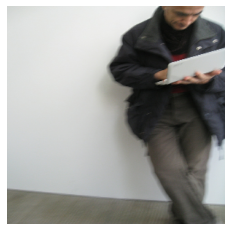

In [85]:
caption_image(img_name_vector_test[22])

<sos> giraffe laying on top of fence in zoo <eos>


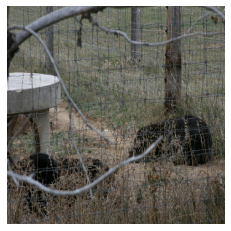

In [89]:
caption_image(img_name_vector_test[400])

<sos> man and woman are standing on skateboard <eos>


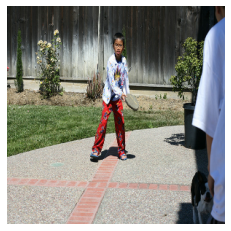

In [98]:
caption_image(img_name_vector_test[9000])

##Saving the dictionary

In [0]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)